In [21]:
from psf_constants import FC_PROCESSED_TRAIN_OUTPUT_FLUXES_PREFIX, \
                          FC_PROCESSED_TRAIN_COMPLEX_FIELDS_PREFIX, \
                          FC_PROCESSED_VALIDATION_OUTPUT_FLUXES_FILE_PATH, \
                          FC_PROCESSED_VALIDATION_COMPLEX_FIELDS_FILE_PATH

from data_utils import load_numpy_data

from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_model, \
                           train_model, \
                           train_model_with_generator, \
                           store_model

from configurations import SimpleFCModel as ModelConfig

from plot_utils import plot_amplitude_phase_intensity_from_complex_field

In [2]:
validation_fluxes_array = load_numpy_data(FC_PROCESSED_VALIDATION_OUTPUT_FLUXES_FILE_PATH)
validation_complex_fields_array = load_numpy_data(FC_PROCESSED_VALIDATION_COMPLEX_FIELDS_FILE_PATH)

In [3]:
validation_fluxes_array.shape

(10000, 19)

In [4]:
validation_complex_fields_array.shape

(10000, 32768)

In [5]:
model_configuration = ModelConfig()
print(model_configuration.get_description())


	=== PSF-FC-Reconstructor ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Fully Connected
		-Input shape: 19
		-Output shape: 32768
		-Hidden layers: [2000, 2000, 2000, 2000]
		-Regularizer: None
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: False
		-Dropout: False, 0.2
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.001, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	*TRAINING HYPERPARAMETERS:
		-Epochs: 200
		-Batch size: 64
		-Callbacks: 
			-ReduceLROnPlateau: MSE 10 x0.1
			-Early Stop: MSE 25
	


2024-02-28 11:13:13.311797: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-02-28 11:13:13.311823: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: dani-Stealth-16Studio-A13VG
2024-02-28 11:13:13.311827: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: dani-Stealth-16Studio-A13VG
2024-02-28 11:13:13.311941: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-02-28 11:13:13.311954: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.154.5
2024-02-28 11:13:13.311957: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.154.5 does not match DSO version 535.161.7 -- cannot find working devices in t

In [6]:
model = create_fully_connected_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "PSF-FC-Reconstructor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              38000     
                                                                 
 activation (Activation)     (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 2000)              4000000   
                                                                 
 activation_1 (Activation)   (None, 2000)              0         
                                                                 
 dense_2 (Dense)             (None, 2000)              4000000   
                                                                 
 activation_2 (Activation)   (None, 2000)              0         
                                                                 
 dense_3 (Dense)             (None, 2000)     

In [7]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

In [8]:
history = train_model_with_generator(
    model,
    FC_PROCESSED_TRAIN_OUTPUT_FLUXES_PREFIX,
    FC_PROCESSED_TRAIN_COMPLEX_FIELDS_PREFIX,
    validation_fluxes_array,
    validation_complex_fields_array,
    *model_configuration.unpack_training_hyperparameters(),
    n_samples=20000
)

Epoch 1/200
313/313 [==============================] - 94s 298ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - lr: 0.0010
Epoch 2/200
313/313 [==============================] - 92s 293ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - lr: 0.0010
Epoch 3/200
313/313 [==============================] - 92s 294ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - lr: 0.0010
Epoch 4/200
313/313 [==============================] - 86s 274ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - lr: 0.0010
Epoch 5/200
313/313 [==============================] - 83s 267ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - lr: 0.0010
Epoch 6/200
313/313 [==============================] - 90s 288ms/step - loss: 0.0370 - mean_squared_error

In [9]:
from plot_utils import plot_model_history

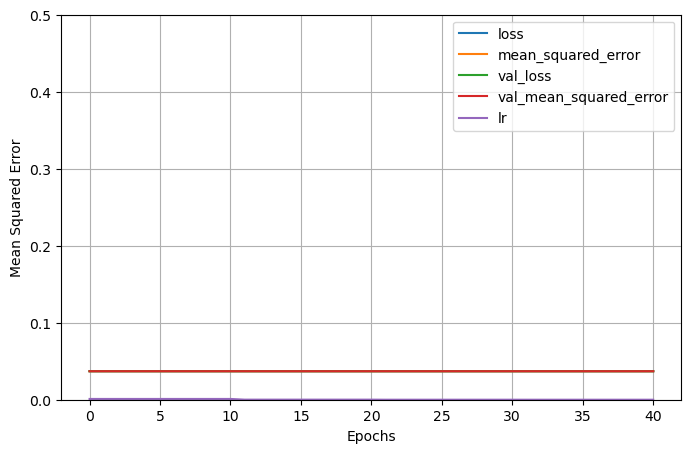

In [10]:
plot_model_history(history)

In [13]:
store_model(model,
            model.name,
            model_configuration.get_description(),
            history.history['mean_squared_error'][-1],
            history.history['val_mean_squared_error'][-1])

1/1 [==============================] - 0s 21ms/step


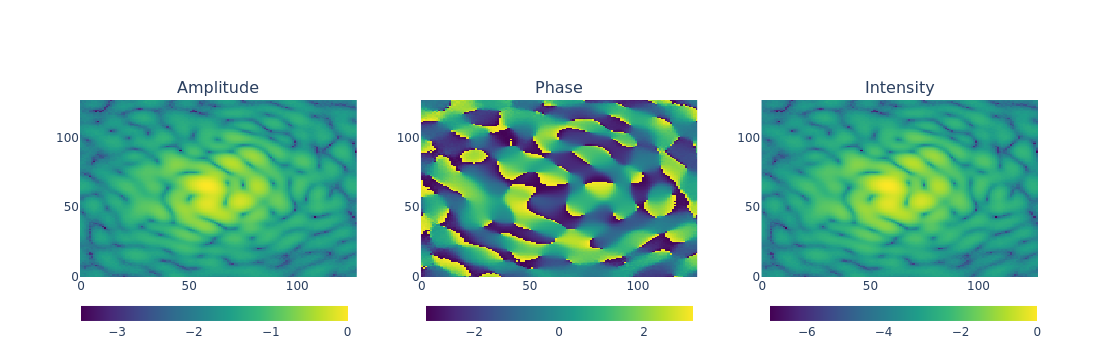

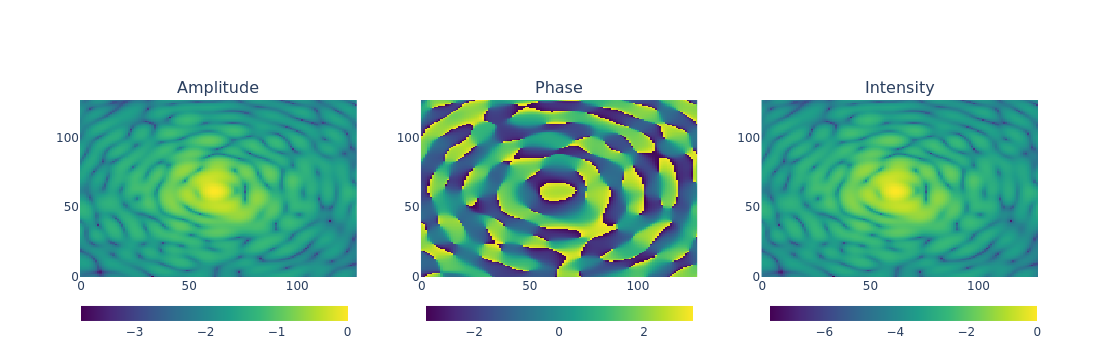

In [28]:
import numpy as np
n = 12
p = model.predict(np.array([validation_fluxes_array[n]]))[0]
p = p.reshape(2, 128, 128)
p = p[0] + 1j*p[1]
plot_amplitude_phase_intensity_from_complex_field(p)
p = validation_complex_fields_array[n]
p = p.reshape(2, 128, 128)
p = p[0] + 1j*p[1]
plot_amplitude_phase_intensity_from_complex_field(p)